# Augmented Reality with Planar Homographies

In [3]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt

In [2]:
def loadVid(path):
	# Create a VideoCapture object and read from input file
	# If the input is the camera, pass 0 instead of the video file name
	cap = cv2.VideoCapture(path)
	 
	# Check if camera opened successfully
	if (cap.isOpened()== False): 
		print("Error opening video stream or file")

	i = 0
	# Read until video is completed
	while(cap.isOpened()):
		# Capture frame-by-frame
		i += 1
		ret, frame = cap.read()
		if ret == True:

			#Store the resulting frame
			if i == 1:
				frames = frame[np.newaxis, ...]
			else:
				frame = frame[np.newaxis, ...]
				frames = np.vstack([frames, frame])
				frames = np.squeeze(frames)
			
		else: 
			break
	 
	# When everything done, release the video capture object
	cap.release()

	return frames


## Getting Correspondences

In [29]:
def find_correspondences(img1,img2):
    img11 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    img22 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
                        
    sift = cv2.SIFT_create()
    # get keypoints and descriptors in each img
    kp1, des1 = sift.detectAndCompute(img11,None)
    kp2, des2 = sift.detectAndCompute(img22,None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
 
    good = []
    for m,n in matches:
        if m.distance/n.distance < 0.65:
            # m contains queryIdx, trainIdx which correspond to the indices of the matched keypoint1,keypoint2 in their respective lists
            good.append([m])
            #print(m.queryIdx)
            #print(m.trainIdx)
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good[:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15,10)), plt.imshow(img3),plt.show()
    
    img1_pts = np.float32([kp1[m.queryIdx].pt for [m] in good]).reshape(-1,1,2)
    img2_pts = np.float32([kp2[m.trainIdx].pt for [m] in good]).reshape(-1,1,2)
    
    correspondences = [(tuple(pt1[0]), tuple(pt2[0])) for pt1, pt2 in zip(img1_pts, img2_pts)]
    
    return correspondences
    
    

In [15]:
img1 = cv2.imread('cv_cover.jpg')
frames = loadVid('book.mov')


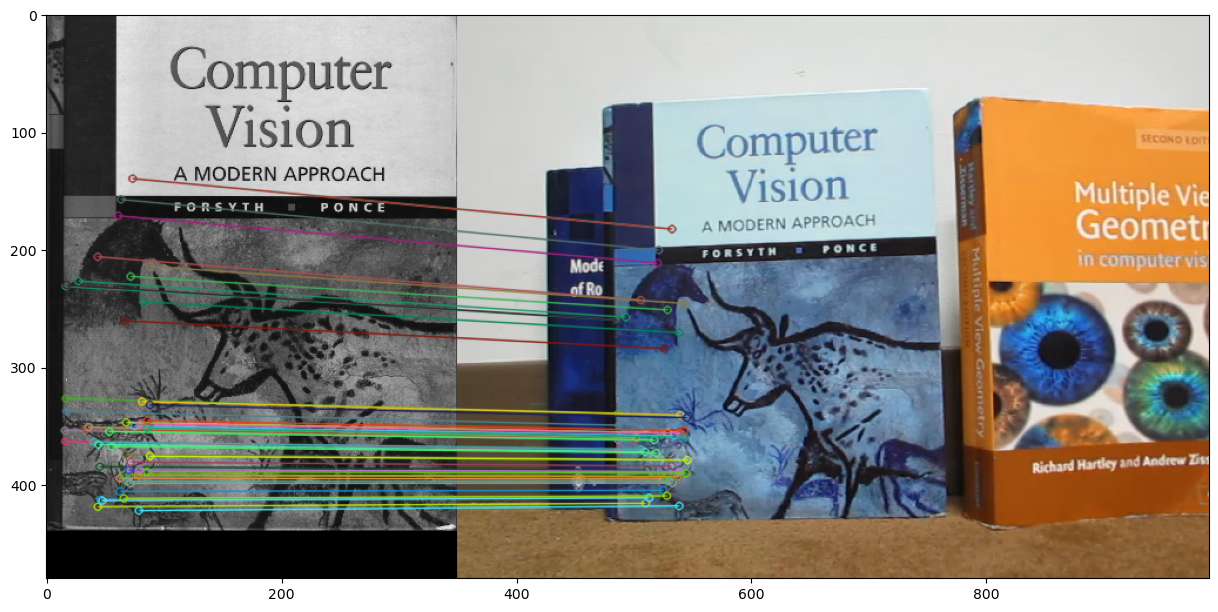

In [30]:
corr = find_correspondences(img1,frames[0])

## Compute the Homography Parameters

In [32]:
def compute_homography(correspondences):
    assert len(correspondences)>=4
    P = []
    for ((x1,y1),(x2,y2)) in correspondences[:4]:
        rows = [[x1, y1, 1, 0, 0, 0, -x1*x2, -y1*x2, -x2],
                [0, 0, 0, x1, y1, 1, -x1*y2, -y1*y2, -y2]]
        P.extend(rows)

    _, __, V = np.linalg.svd(np.array(P))
    H = V[-1, :] / V[-1,-1]
    return H.reshape((3,3))


In [34]:
H = compute_homography(corr)
H

array([[-8.68354993e+00,  1.99115036e-03,  1.36913232e+02],
       [-2.26074387e+01, -2.32322875e-02,  3.66574799e+02],
       [-6.34661718e-02,  1.64914308e-05,  1.00000000e+00]])